In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True # 
plt.ion()   # Turns the interactive mode on

**Question 1(b) Modify the code to run on co-lab without any new features.** 

In the below code we have made necessary changes to the original code such that the program may run without any additional modifications to the original code. The path of the data folders is taken from the google drive which is mounted along with this colab notebook.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
# Here we load the data
#Compose: Composes several transforms together
#ToTensor: Convert a PIL Image or numpy.ndarray to tensor.
#Normalize: Normalizes a tensor image with mean and standard deviation.
#RandomHorizontalFlip: Horizontally flip the given image randomly with a given probability.
#RandomResizedCrop: Crop a random portion of image and resize it to a given size.
'''
References: https://pytorch.org/vision/stable/transforms.html
https://pytorch.org/vision/stable/datasets.html
https://pytorch.org/docs/stable/data.html#module-torch.utils.data
'''

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/EE 752 Introduction to ML/Assignment 3/hymenoptera_data'  # Take data from the given directory

# ImageFolder: A generic data loader where the images are arranged in this way by default.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}  # Apply data transforms to train and val data 
#dataloaders: It represents a Python iterable over a dataset
#batch_size (int, optional) – how many samples per batch to load (default: 1)
#shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False)
#num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} # Iterate in training and validation images)
class_names = image_datasets['train'].classes   # Gives the names of classes present in the training dataframe
# A torch.device is an object representing the device on which a torch.Tensor is or will be allocated.
# The torch.device contains a device type ('cpu' or 'cuda') and optional device ordinal for the device type.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


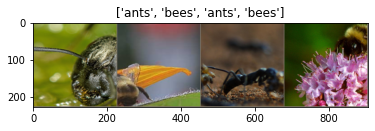

In [ ]:
'''
References: https://numpy.org/doc/stable/reference/generated/numpy.clip.html
'''

# Below code is used to visualize a few images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # Means of R, G, and B
    std = np.array([0.229, 0.224, 0.225]) # Standard deviations of R, G and B
    inp = std * inp + mean  # Removes the normalization from the normalized image
    inp = np.clip(inp, 0, 1) #Given an interval, values outside the interval are clipped to the interval edges.
    #For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
    plt.imshow(inp) # Shows the image
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))  #Python next() function returns the next item of an iterator.

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) 
imshow(out, title=[class_names[x] for x in classes])  # Title of image is the class_name

In [ ]:
'''
References: https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html
https://docs.python.org/3/library/copy.html
https://www.geeksforgeeks.org/matplotlib-pyplot-plot-function-in-python/

'''

#Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #time.time() method of Time module is used to get the time in seconds since epoch
    #Assignment statements in Python do not copy objects, they create bindings between a target and an object.
    #For collections that are mutable or contain mutable items, a copy is sometimes needed so one can change one copy without changing the other
    best_model_wts = copy.deepcopy(model.state_dict())  # A state_dict is an integral entity if you are interested in saving or loading models from PyTorch. Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers. 
    # Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict
    best_acc = 0.0
    validation_loss = np.zeros(num_epochs)  # Define two numpy arrays to plot the validation loss and accuracy after every iteration 
    validation_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)  # Define two numpy arrays to plot the validation loss and accuracy after every iteration 
    train_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        xaxis = range(num_epochs)
        index = 0
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: # Phase can be training phase or validation phase
                inputs = inputs.to(device)  #
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
  
            if phase == 'train':
                scheduler.step()
        

            epoch_loss = running_loss / dataset_sizes[phase]  # This is the loss of current epoch training loss & validation loss
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
           
            if phase == 'train':
              train_loss[epoch] = epoch_loss
              train_acc[epoch] = epoch_acc
              if epoch>0 and abs(train_acc[epoch] - train_acc[epoch-1]) <= 0.09:
                time_elapsed = time.time() - since
                

          
            
            if phase == 'val':
              validation_loss[epoch] = epoch_loss
              validation_acc[epoch] = epoch_acc
              #index = index+1
              #np.append(validation_loss,epoch_loss)
              #np.append(validation_acc,epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if phase=='val':
          plt.plot(xaxis, np.array(validation_loss), color ='tab:blue', label = 'validation_loss') 
          plt.plot(xaxis, np.array(validation_acc), color ='tab:orange', label = 'validation_accuracy')
          plt.title('Validation accuracy and validation loss for epoch'+str(epoch))
          plt.legend()
          plt.show()            

        
    plt.plot(xaxis, np.array(train_loss), color ='tab:blue', label = 'train_loss') 
    plt.plot(xaxis, np.array(train_acc), color ='tab:orange', label = 'train_accuracy')
    plt.title('train accuracy and train loss')
    plt.legend()
    plt.show()
    print('Training loss:',train_loss)
    time_elapsed = time.time() - since  # Find the total time elapsed for each epoch
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}') # Prints the best validation accuracy

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Visualize the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # Change the learning rate, momentum and weight decay here
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1000) # Change the learning rate, momentum and weight decay here
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5085 Acc: 0.7418
val Loss: 0.2368 Acc: 0.9150


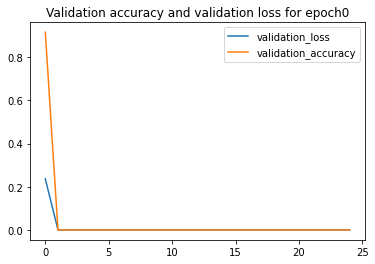

Epoch 1/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5299 Acc: 0.7500
val Loss: 0.2146 Acc: 0.9216


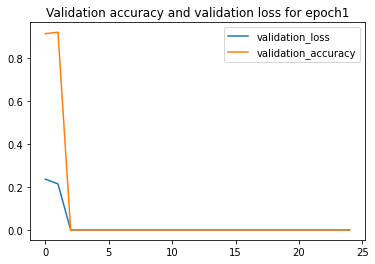

Epoch 2/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5788 Acc: 0.8033
val Loss: 0.2044 Acc: 0.9216


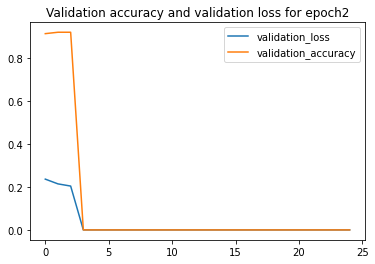

Epoch 3/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4298 Acc: 0.8197
val Loss: 0.2994 Acc: 0.9085


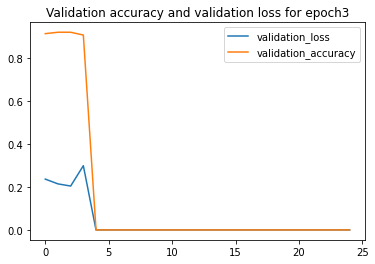

Epoch 4/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5284 Acc: 0.7623
val Loss: 0.4132 Acc: 0.8627


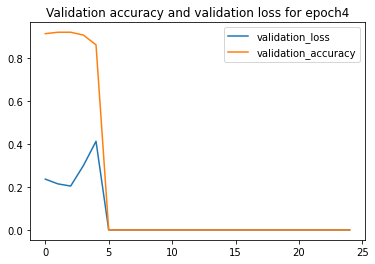

Epoch 5/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4748 Acc: 0.8361
val Loss: 0.2955 Acc: 0.8889


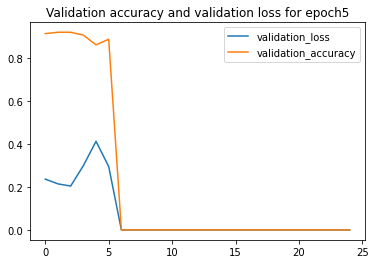

Epoch 6/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5229 Acc: 0.7787
val Loss: 0.1877 Acc: 0.9281


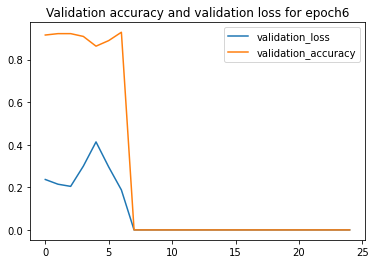

Epoch 7/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3090 Acc: 0.8607
val Loss: 0.2041 Acc: 0.9020


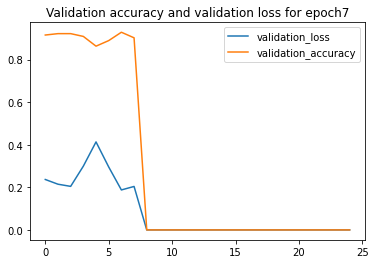

Epoch 8/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3832 Acc: 0.8443
val Loss: 0.1807 Acc: 0.9150


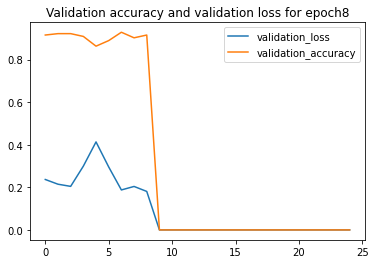

Epoch 9/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3665 Acc: 0.8402
val Loss: 0.1783 Acc: 0.9281


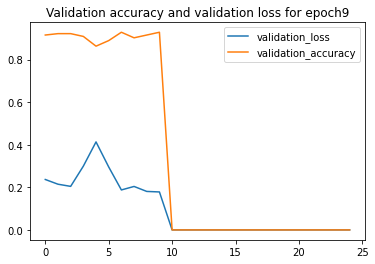

Epoch 10/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2903 Acc: 0.8770
val Loss: 0.1672 Acc: 0.9412


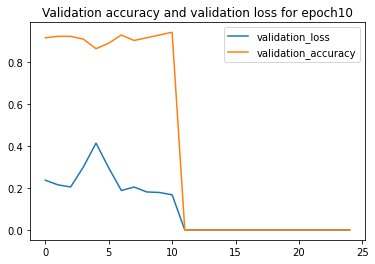

Epoch 11/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3103 Acc: 0.8566
val Loss: 0.1725 Acc: 0.9281


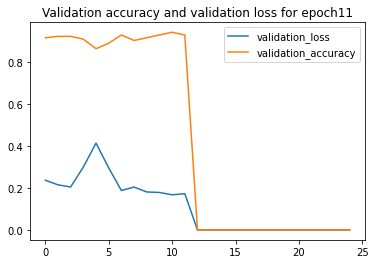

Epoch 12/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3752 Acc: 0.8402
val Loss: 0.1741 Acc: 0.9216


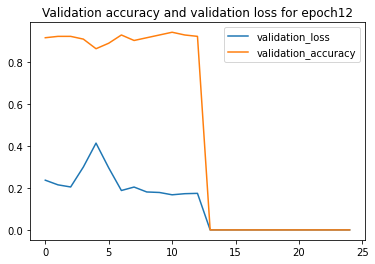

Epoch 13/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2457 Acc: 0.9057
val Loss: 0.1533 Acc: 0.9346


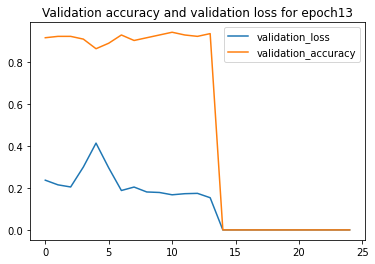

Epoch 14/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2785 Acc: 0.8770
val Loss: 0.1687 Acc: 0.9412


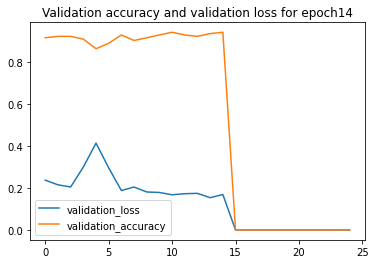

Epoch 15/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2646 Acc: 0.8934
val Loss: 0.1859 Acc: 0.9216


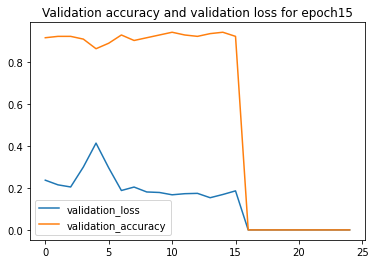

Epoch 16/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2635 Acc: 0.8811
val Loss: 0.1728 Acc: 0.9020


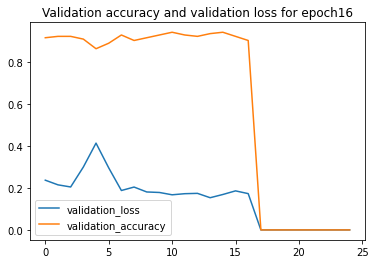

Epoch 17/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2308 Acc: 0.9221
val Loss: 0.1661 Acc: 0.9281


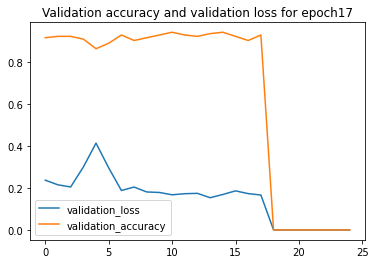

Epoch 18/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3139 Acc: 0.8566
val Loss: 0.1644 Acc: 0.9281


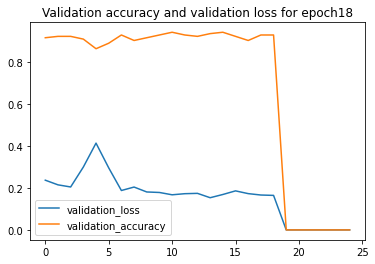

Epoch 19/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2545 Acc: 0.9180
val Loss: 0.1678 Acc: 0.9346


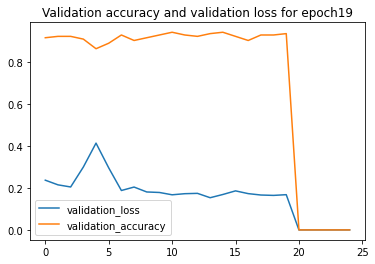

Epoch 20/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3191 Acc: 0.8648
val Loss: 0.1528 Acc: 0.9412


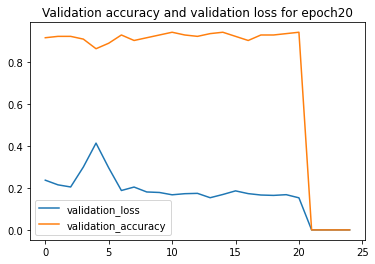

Epoch 21/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3252 Acc: 0.8566
val Loss: 0.1756 Acc: 0.9216


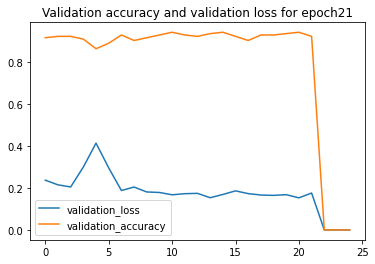

Epoch 22/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3228 Acc: 0.8730
val Loss: 0.1738 Acc: 0.9085


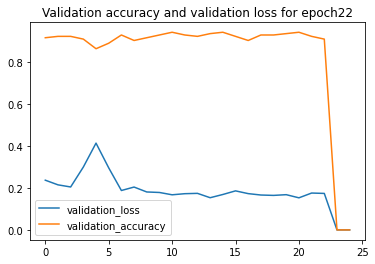

Epoch 23/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3455 Acc: 0.8443
val Loss: 0.1598 Acc: 0.9085


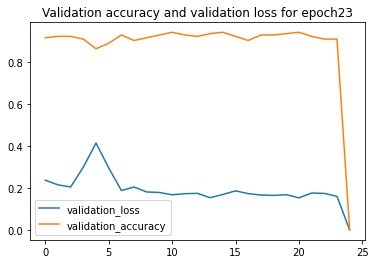

Epoch 24/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2517 Acc: 0.8852
val Loss: 0.1648 Acc: 0.9281


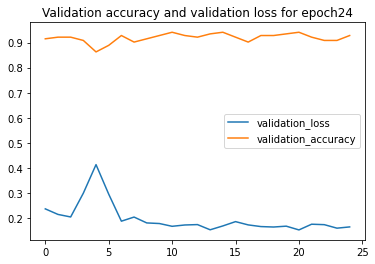

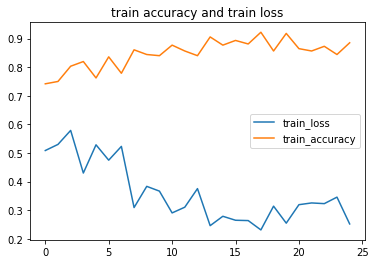

Training loss: [0.50847518 0.52986528 0.57881032 0.42975507 0.52842105 0.47475134
 0.52289337 0.30903413 0.38316103 0.36649445 0.29029785 0.31030641
 0.37523445 0.24570726 0.27852667 0.26463417 0.26350766 0.2308329
 0.31392299 0.25445585 0.31908035 0.32516073 0.32275467 0.34546064
 0.25173925]
Training complete in 3m 25s
Best val Acc: 0.941176


In [ ]:
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


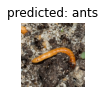

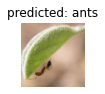

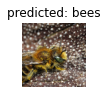

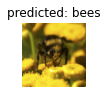

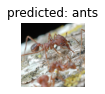

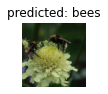

In [ ]:
visualize_model(model_ft)

In [ ]:

#ConvNet as fixed feature extractor

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# Change learning rate, momentum and weight decay in following two lines 
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=1000)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6577 Acc: 0.7090
val Loss: 0.2107 Acc: 0.9412


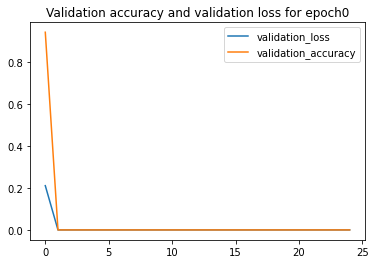

Epoch 1/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4991 Acc: 0.7787
val Loss: 0.3452 Acc: 0.8562


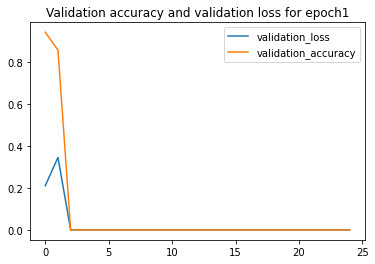

Epoch 2/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4745 Acc: 0.8074
val Loss: 0.1537 Acc: 0.9542


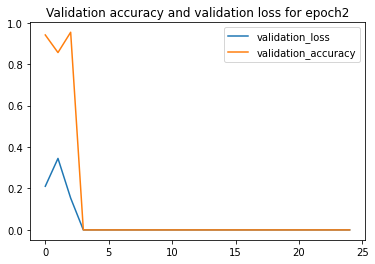

Epoch 3/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3569 Acc: 0.8320
val Loss: 0.2244 Acc: 0.9346


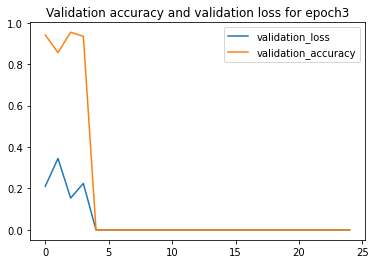

Epoch 4/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4362 Acc: 0.8033
val Loss: 0.1555 Acc: 0.9542


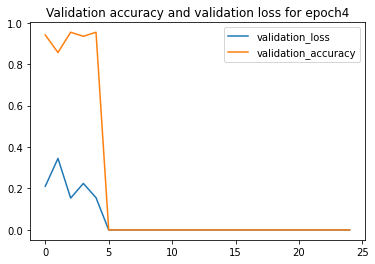

Epoch 5/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6179 Acc: 0.7336
val Loss: 0.1624 Acc: 0.9477


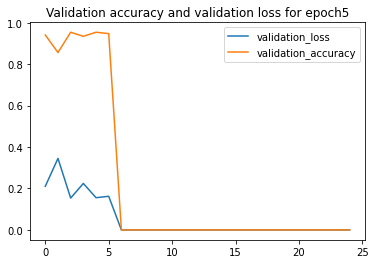

Epoch 6/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3460 Acc: 0.8607
val Loss: 0.1843 Acc: 0.9412


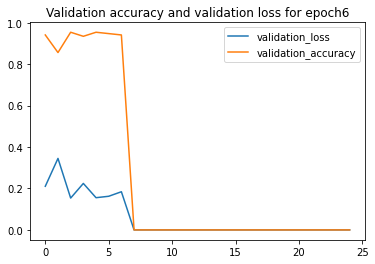

Epoch 7/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3662 Acc: 0.8484
val Loss: 0.1857 Acc: 0.9346


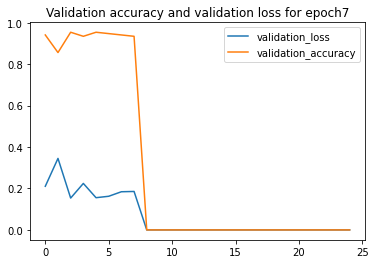

Epoch 8/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3602 Acc: 0.8443
val Loss: 0.2159 Acc: 0.9216


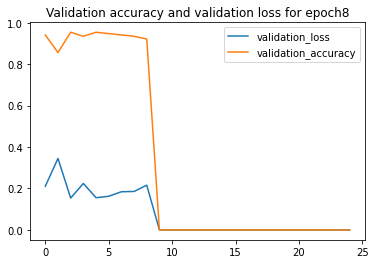

Epoch 9/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2700 Acc: 0.8934
val Loss: 0.1806 Acc: 0.9477


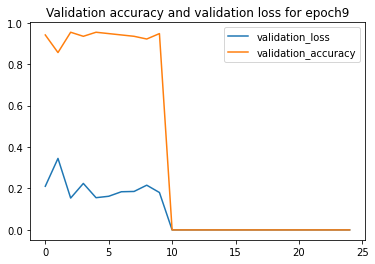

Epoch 10/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3527 Acc: 0.8402
val Loss: 0.2150 Acc: 0.9216


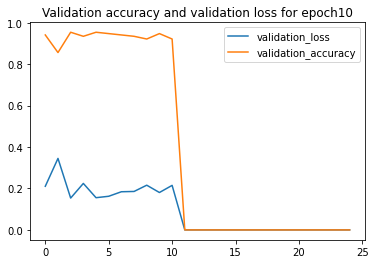

Epoch 11/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3754 Acc: 0.8320
val Loss: 0.1865 Acc: 0.9216


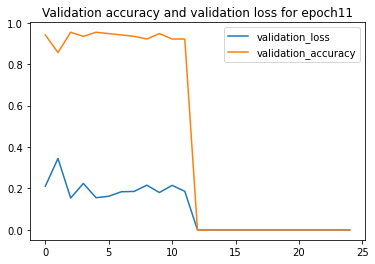

Epoch 12/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3276 Acc: 0.8607
val Loss: 0.1966 Acc: 0.9281


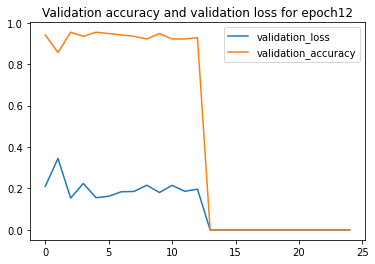

Epoch 13/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2865 Acc: 0.8770
val Loss: 0.1746 Acc: 0.9346


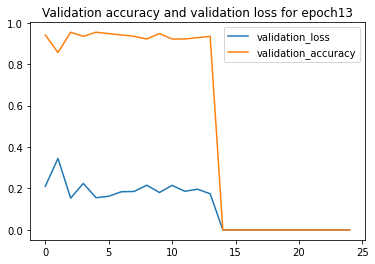

Epoch 14/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3434 Acc: 0.8320
val Loss: 0.1966 Acc: 0.9281


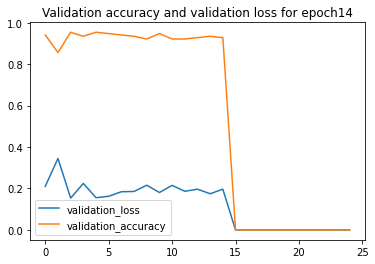

Epoch 15/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3112 Acc: 0.8770
val Loss: 0.1683 Acc: 0.9477


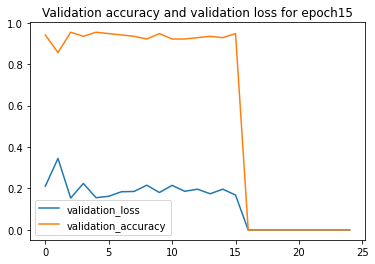

Epoch 16/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3139 Acc: 0.8361
val Loss: 0.1904 Acc: 0.9412


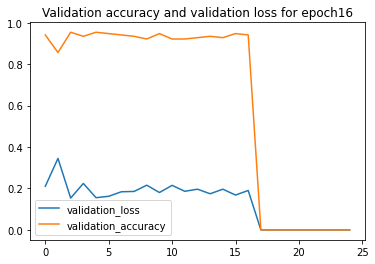

Epoch 17/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3623 Acc: 0.8566
val Loss: 0.1979 Acc: 0.9412


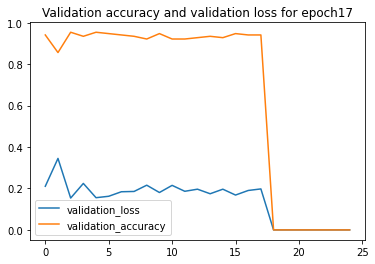

Epoch 18/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2834 Acc: 0.8934
val Loss: 0.1797 Acc: 0.9477


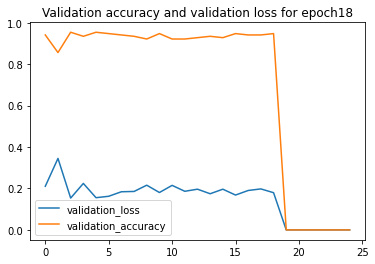

Epoch 19/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2688 Acc: 0.8770
val Loss: 0.1781 Acc: 0.9412


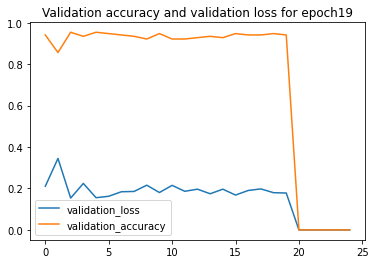

Epoch 20/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2605 Acc: 0.8934
val Loss: 0.1863 Acc: 0.9412


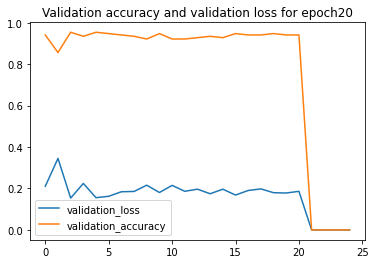

Epoch 21/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3823 Acc: 0.8443
val Loss: 0.1715 Acc: 0.9412


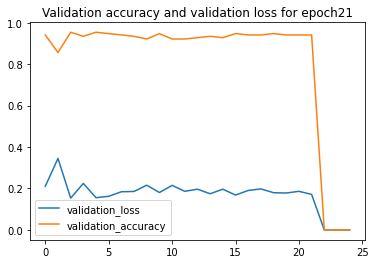

Epoch 22/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2780 Acc: 0.8811
val Loss: 0.1786 Acc: 0.9542


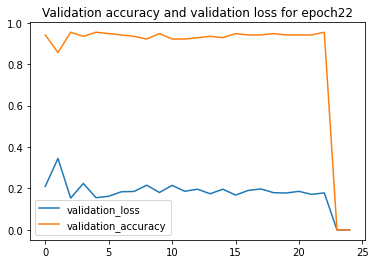

Epoch 23/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3507 Acc: 0.8238
val Loss: 0.1642 Acc: 0.9412


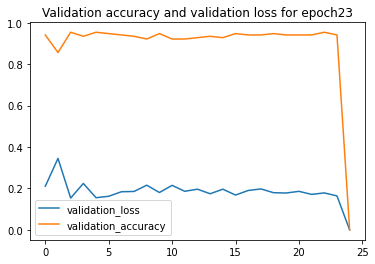

Epoch 24/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3445 Acc: 0.8525
val Loss: 0.2114 Acc: 0.9281


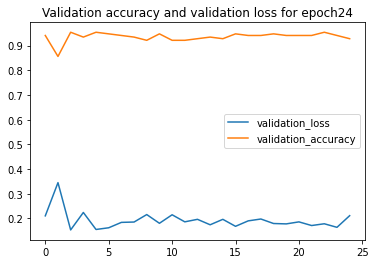

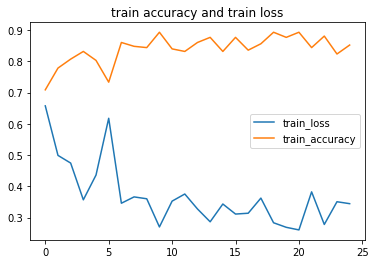

Training loss: [0.65770091 0.49911024 0.47451476 0.35685534 0.43618601 0.61792883
 0.34595065 0.36619663 0.36019584 0.27001752 0.35265392 0.37543176
 0.32759593 0.28648511 0.34341074 0.31124985 0.31391051 0.36234371
 0.2833818  0.26881236 0.26046748 0.38233218 0.27796122 0.35071206
 0.34449768]
Training complete in 2m 22s
Best val Acc: 0.954248


In [ ]:
#Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


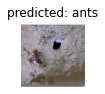

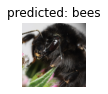

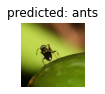

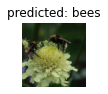

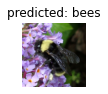

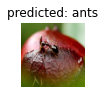

In [ ]:
visualize_model(model_conv)
plt.ioff()
plt.show()

**Question 1(d) Change the learning rate, momentum, and number of epochs at least three times to see the net effect on final validation loss and accuracy and its speed of convergence**

We will observe the validation accuracy and speed of convergence based on the following values of learning rate (lr), momentum(m) and number of epochs(numEpochs): 

lr = 0.001, 0.01, 0.1; m = 0.6, 0.8, 0.9, 0.85, 0.5; numEpochs = 25, 35, 40, 45, 50

Speed of convergence is measured based on decrease in validation loss with respect to number of epochs = (initial loss-final loss)/numEpochs

The following changes to the parameters were done to the **fixed** and **fine-tuned** feature extractors.

**Observations:**

1) lr = 0.001, m = 0.6, numEpochs = 25: final validation accuracy = 0.954248  speed of convergence = validation loss changed from 0.2386 to 0.1831 in 14 epochs 

2) lr = 0.01, m = 0.9, numEpochs = 50: final validation accuracy = 0.5882 speed of convergence = validation loss changed from 13.4844 to 1.1458  in 12 epochs.

3) lr = 0.1, m = 0.85, numEpochs = 40: final validation accuracy = 0.5686 speed of convergence = validation loss changed from 3.8152 to 0.7022  in 15 epochs.

4) lr = 0.001, m = 0.5, numEpochs = 45: final validation accuracy = 0.9346 speed of convergence = validation loss changed from 0.3543 to 0.1854 in 23 epochs. 

5) lr = 0.001, m = 0.95, numEpochs = 50: final validation accuracy = 0.9542 speed of convergence = validation loss changed from 0.5571 to 0.2342 in 15 epochs.

6) lr = 0.01, m = 0.8, numEpochs = 35: final validation accuracy = 0.6601  speed of convergence = validation loss changed from 3.9921 to 0.6801 in 17 epochs.

**Observations:**

1) The validation loss vs epochs curve is much smoother as compared to training loss vs epochs curve. 

2) For a learning rate of 0.01 and 0.1  there are sudden spikes in the initial part of training and validation loss vs epochs curve.

3) Validation accuracy decreased as we changed the original learning rate form 0.001 to 0.01 and 0.1.

4) Momentum is designed to accelerate the optimization process or decrease the number of function evaluations required to reach the optima. For lesser values of momentum we need more number of epochs to converge than that required when we give higher values of momentum.

5) Momentum = 0.8 or 0.9 works well for most of the problems.

6) Increasing the number of epochs does not means an increase in validation accuracy.

7) Rate of convergence increases as we increase the momentum and learning rate. 

**Question 1(e) introduce weight decay (L2 penalty on weights) and find a good value for the weight decay factor**

Source: https://www.statisticshowto.com/regularization/#:~:text=Lasso%20regression%20uses%20this%20method,factor%20(none%20are%20eliminated).

Regularization is a way to avoid overfitting by penalizing high-valued regression coefficients. In simple terms, it reduces parameters and shrinks (simplifies) the model. This more streamlined model will likely perform better at predictions. 

This means that validation accuracy should increase due to introduction of L2 penalty. Regularization results in a better fit on unseen data and better generalization.

**Observations:**

We tried the following values of L2 penalty lamda = 0.001, 0.01, 0.1, 1, 10, 100. learning rate = 0.001, numEpochs = 25, momentum = 0.9:

1) lamda = 0.001: maximum validation accuracy (finetuned Convnet) = 0.9150;
maximum validation accuracy (Fixed feature extractor) = 0.9477

2) lamda = 0.01: maximum validation accuracy (finetuned Convnet) = 0.947712;
maximum validation accuracy (Fixed feature extractor) = 0.960784

3) lamda = 0.1: maximum validation accuracy (finetuned Convnet) = 0.9216;
maximum validation accuracy (Fixed feature extractor) = 0.960784

4) lamda = 1: maximum validation accuracy (finetuned Convnet) = 0.575163;
maximum validation accuracy (Fixed feature extractor) = 0.960784

5) lamda = 10: maximum validation accuracy (finetuned Convnet) = 0.542484;
maximum validation accuracy (Fixed feature extractor) = 0.6144

6) lamda = 100: maximum validation accuracy (finetuned Convnet) = 0.542484;
maximum validation accuracy (Fixed feature extractor)= 0.941176

7) lamda = 1000: maximum validation accuracy (finetuned Convnet) = 0.542484;
maximum validation accuracy (Fixed feature extractor) = 0.915033

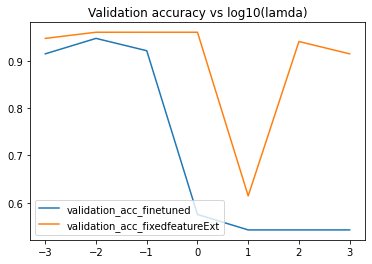

In [ ]:
xaxis = [pow(10,i) for i in range(-3,4)]
xaxis = np.log10(xaxis)
plt.plot(xaxis, [ 0.9150, 0.9477, 0.9216, 0.5751, 0.5424, 0.5424, 0.5424], color ='tab:blue', label = 'validation_acc_finetuned') 
plt.plot(xaxis, [0.9477, 0.9607,0.9607,0.9607,0.6144,0.9411,0.9150], color ='tab:orange', label = 'validation_acc_fixedfeatureExt')
plt.title('Validation accuracy vs log10(lamda)')
plt.legend()
plt.show()

**Observations:**

1) From the above plot between Validation accuracy vs log10(lamda) we can clearly see that for both "fixed feature extractor" and "finetuned convnet" the maximum validation accuracy occurs at lamda = 0.01 for learning rate = 0.001, momentum = 0.9 and numEpochs = 25.

2) Therefore the optimum value of L2 penalty is lamda = 0.01. 